# SD for the Sound-soft scattering

For a suitably defined perturbation of the initial shape, we compare the RCSs of $\text{U}_t$ versus $\text{U}$ the zeroth order approximation and $(\text{U} + t \text{U}')$ the FOA. In this tutorial we consider the kite-shaped object and the perturbation field of Subsection 7.1.

In [28]:
import bempp.api as bem
import numpy as np
from kite import kite
from matplotlib import pyplot as plt
%matplotlib inline

Set the parameters for the H-mat assembly and gmres:

In [29]:
bem.global_parameters.hmat.max_block_size = 1000
bem.global_parameters.hmat.eps = 0.00001

maxiter = 2000
restart = 2000

Set the wavenumber $\kappa$ and the evaluation points for the RCS.

In [41]:
k0 = 1 #wavenumber
precision = 20 #number of elements per waveleng

tolerance = 1E-4
h = 2.0 * np.pi / (precision * k0)

t = 0.05
theta = np.linspace(0, 2 * np.pi, 400)
points = np.array([np.cos(theta), np.sin(theta), np.zeros(len(theta))])


We define the perturbation field $\mathbf{v}$ and set a routine that transforms the geometry of the original mesh. Then, we introduce the Cauchy data.

In [42]:
def change_normal(elements):
    return np.array([elements[0,:],elements[2,:],elements[1,:]])

def Phix(x, n, domain_index, result):
    angle = np.arctan2(x[1],x[0]) 
    x1 =  (1-x[2]**2) * (np.cos(2 * angle) - 1)
    result[0] = x1

def Phiy(x, n, domain_index, result):
    angle =  np.arctan2(x[1],x[0]) 
    y1 = 0.25 * np.sin(angle) *  (1- x[2]**2)
    result[0] = y1

def perturbate(grid, t, kappa_pert=None):
    P1 = bem.function_space(grid, 'P', 1)
    grid_funx = bem.GridFunction(P1, fun = Phix)
    grid_funy = bem.GridFunction(P1, fun = Phiy)
    elements = grid.leaf_view.elements
    vertices = grid.leaf_view.vertices
    normals = P1.global_dof_normals
    x, y, z = vertices
    vertices[0, :] = x + t * grid_funx.coefficients
    vertices[1, :] = y + t * grid_funy.coefficients

    c = normals[0,:] * grid_funx.coefficients + normals[1,:] * grid_funy.coefficients

    kappa = bem.GridFunction(P1, coefficients = c)
    if kappa_pert is None:
        return bem.grid_from_element_data(vertices, elements)
    else:
        return bem.grid_from_element_data(vertices, elements), kappa

def dirichlet_fun(x, n, domain_index, result):
    result[0] = np.exp(1j * k0 * x[0])

def neumann_fun(x, n, domain_index, result):
    result[0] = 1j * k0 * np.exp(1j * k0 * x[0]) * n[0]



We discretize the BIEs related to $\text{U}$ and $\text{U}'$, namely:

$$ \text{V}_\kappa \gamma_1 \text{U} = \gamma_0 \text{U}^\text{inc},$$
and
$$ \text{V}_\kappa \gamma_1 \text{U}' = \Big(-\frac{1}{2}\text{Id} + \text{K}_\kappa\Big)g_0,$$
with 
$$
g_0 := - \gamma_1\text{U}(\mathbf{v}\cdot\mathbf{n}).
$$


In [43]:
#gr = bem.shapes.sphere(h=h)
gr = kite(h=h)

gr, kappa  = perturbate(gr, 0, kappa_pert=1)
sp = bem.function_space(gr, 'P', 1)

print int(sp.global_dof_count), 'N'

V = bem.operators.boundary.helmholtz.single_layer(sp, sp, sp, k0)
K = bem.operators.boundary.helmholtz.double_layer(sp, sp, sp, k0)
W = bem.operators.boundary.helmholtz.hypersingular(sp, sp, sp, k0)
I = bem.operators.boundary.sparse.identity(sp, sp, sp)

# rhs for the nominal domain
df =  bem.GridFunction(sp, fun = dirichlet_fun)

max_incident = np.abs(df.coefficients).max()

# solver for the nominal domain
phi0, info, res = bem.linalg.gmres(W * V, W * df, tol=tolerance, return_residuals=True, use_strong_form=True, maxiter=maxiter, restart = restart)
ref0 = phi0.l2_norm()

# rhs for the SD
fun1 = bem.GridFunction(sp, coefficients = kappa.coefficients * phi0.coefficients)
rhs1 = -0.5 * I + K
rhsp = rhs1 * (-fun1)

# solver for the SD
phi1, info, res = bem.linalg.gmres(W * V, W * rhsp, tol=tolerance, return_residuals=True, use_strong_form=True, maxiter=maxiter, restart = restart)

# Volume solution:
slp_far_field = bem.operators.far_field.helmholtz.single_layer(sp, points, k0)
dlp_far_field = bem.operators.far_field.helmholtz.double_layer(sp, points, k0)

U0 = -slp_far_field * phi0 
U1 =  -slp_far_field * phi1 + dlp_far_field * (-fun1)

rp0 = (np.abs(U0)**2).ravel()
dbp0 = 10 * np.log10(4 * np.pi * (rp0/max_incident)**2)

rpp = (np.abs(U1)**2).ravel()
dbpp = 10 * np.log10(4 * np.pi * (rpp/max_incident)**2)


183 N


Now, we perturb the nominal shape and solve the scattering problem:

In [44]:
grt = perturbate(gr, t)
spt = bem.function_space(grt, 'P', 1)	

Vt = bem.operators.boundary.helmholtz.single_layer(spt, spt, spt, k0)
Kt = bem.operators.boundary.helmholtz.double_layer(spt, spt, spt, k0)
Wt = bem.operators.boundary.helmholtz.hypersingular(spt, spt, spt, k0)
It = bem.operators.boundary.sparse.identity(spt, spt, spt)

dft =  bem.GridFunction(spt , fun = dirichlet_fun)
phit, infot, rest = bem.linalg.gmres(Wt * Vt, Wt *  dft, tol=tolerance, return_residuals=True, use_strong_form=True, maxiter=maxiter, restart=restart)

slp_far_fieldt = bem.operators.far_field.helmholtz.single_layer(spt, points, k0)

Ut = -slp_far_fieldt * phit 
rpt = np.abs(Ut).ravel()
dbpt = 10 * np.log10(4 * np.pi * (rpt/max_incident)**2)

err0 = np.abs(U0 - Ut).sum() / np.abs(Ut).sum()


U1p = U0 + t * U1
rptp = np.abs(U1p).ravel()
dbptp = 10 * np.log10(4 * np.pi * (rptp/max_incident)**2)

err1 = np.abs(U1p - Ut).sum() / np.abs(Ut).sum()



We compare the Relative $L^2$-error on $\mathbb{S}^1$ of the far-field:

In [45]:
print err0, 'zeroth order error'
print err1, 'first order error'

0.0233391781021 zeroth order error
0.00194047535028 first order error


We plot the RCS patterns (in dB):

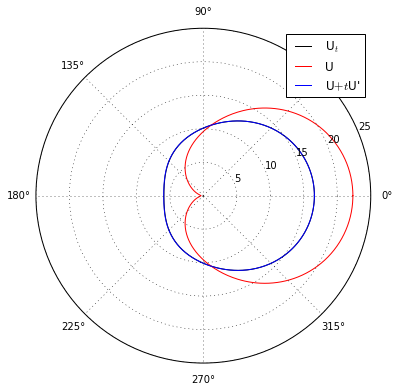

In [46]:
fig = plt.figure(figsize=(12,6))
ax1 = fig.add_subplot(111, projection='polar')
ax1.plot(theta, dbpt, 'k', label=r'U$_t$')
ax1.plot(theta, dbp0, 'r',label=r'U')
ax1.plot(theta, dbptp, 'b', label=r"U$+t$U'")
plt.legend()